#  Climate Impact on Crop Yield – ML Project

###  Problem Statement:
Climate change is significantly impacting crop yields across the globe. Unpredictable rainfall, extreme temperatures, and shifting weather patterns are affecting agricultural productivity.

As a Machine Learning Engineer, I was tasked with building models that can:
- **Predict actual crop yield (Regression)**
- **Classify yield levels (High, Medium, Low) (Classification)**

###  Input:
- Rainfall
- Minimum/Maximum temperature
- CO2 emissions
- Soil type, Crop type, etc.

###  Output:
- A numerical value for yield prediction (in tons/hectare)
- A category (High, Medium, Low yield)

###  Technologies Used:
- Python, Pandas, NumPy, Matplotlib
- TensorFlow (MLP for regression/classification)
- SHAP (Explainability)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import shap

### data loading

In [9]:

df = pd.read_csv("crop_yield.csv")
df.head()


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [10]:
df

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251
...,...,...,...,...,...,...,...,...,...,...
999995,West,Silt,Rice,302.805345,27.987428,False,False,Sunny,76,1.347586
999996,South,Chalky,Barley,932.991383,39.661039,True,False,Rainy,93,7.311594
999997,North,Peaty,Cotton,867.362046,24.370042,True,False,Cloudy,108,5.763182
999998,West,Silt,Wheat,492.812857,33.045505,False,False,Sunny,102,2.070159


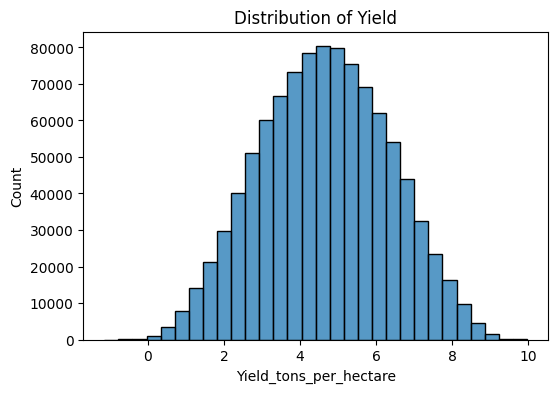

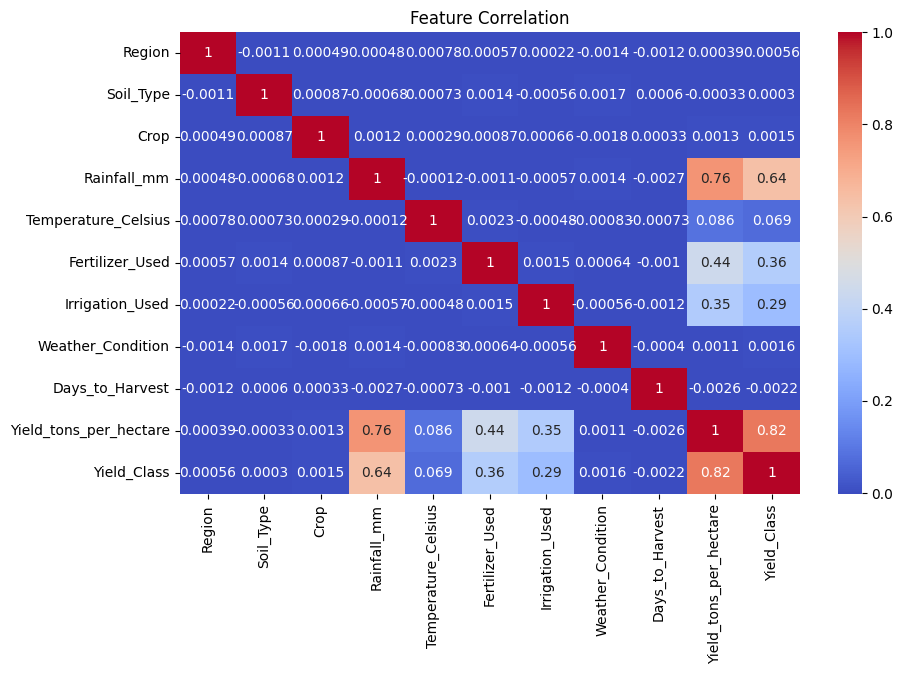

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of Yield
plt.figure(figsize=(6,4))
sns.histplot(df['Yield_tons_per_hectare'], bins=30)
plt.title("Distribution of Yield")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


### Data Exploration & Cleaning


In [11]:
# Basic info
df.info()

# Check for missing values
df.isnull().sum()

# Statistical summary
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


### Feature Engineering

In [9]:
# Create dummy rainfall anomaly (example: subtract mean)
df["Rainfall_Anomaly"] = df["Rainfall_mm"] - df["Rainfall_mm"].mean()

# You can do similar with temperature
df["Temp_Deviation"] = df["Temperature_Celsius"] - df["Temperature_Celsius"].mean()


### Encode Categorical Features & Normalize


In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical columns
cat_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

# Convert boolean to int
df['Fertilizer_Used'] = df['Fertilizer_Used'].astype(int)
df['Irrigation_Used'] = df['Irrigation_Used'].astype(int)

# Scale numerical features
features = df.drop("Yield_tons_per_hectare", axis=1)
target = df["Yield_tons_per_hectare"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


### Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.2, random_state=42)


### Model Building (MLP with TensorFlow)
**Regression Model Architecture:**

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)


/home/iftikhar-ali/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - loss: 0.2862 - mae: 0.4173 - val_loss: 0.2547 - val_mae: 0.4029
Epoch 2/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - loss: 0.2583 - mae: 0.4054 - val_loss: 0.2566 - val_mae: 0.4044
Epoch 3/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - loss: 0.2568 - mae: 0.4042 - val_loss: 0.2656 - val_mae: 0.4111
Epoch 4/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - loss: 0.2560 - mae: 0.4036 - val_loss: 0.2500 - val_mae: 0.3993
Epoch 5/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 111s 6ms/step - loss: 0.2553 - mae: 0.4030 - val_loss: 0.2531 - val_mae: 0.4017
Epoch 6/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - loss: 0.2549 - mae: 0.4027 - val_loss: 0.2553 - val_mae: 0.4033
Epoch 7/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - loss: 0.2546 - mae: 0.4025 - val_loss: 0.2499 - val_mae: 0.3992
Epoch 8/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 0.2544 - mae: 0.4023 - val_loss: 0.2503 - val_mae: 0.3996
Epoch 9/

### Evaluate Regression Model:

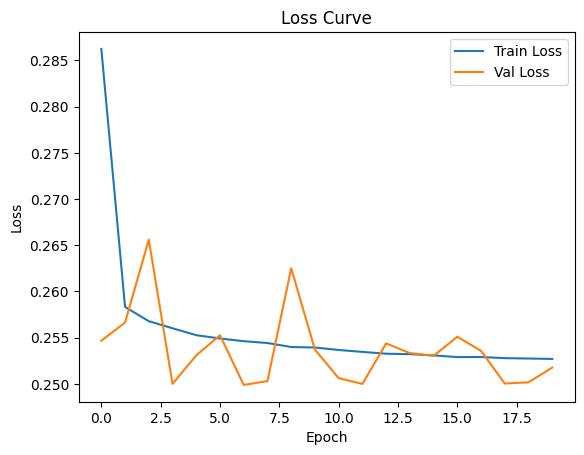

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
MSE: 0.2536562107508204
R² Score: 0.912014951856993


In [16]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


### Convert Regression to Classification


In [17]:
# Categorize yield: Low (< 2), Medium (2–4), High (> 4)
def categorize_yield(y):
    if y < 2:
        return 0  # Low
    elif y <= 4:
        return 1  # Medium
    else:
        return 2  # High

df["Yield_Class"] = df["Yield_tons_per_hectare"].apply(categorize_yield)

# Update target
target_cls = df["Yield_Class"]
features_cls = df.drop(["Yield_tons_per_hectare", "Yield_Class"], axis=1)

# Re-scale
features_cls_scaled = scaler.fit_transform(features_cls)

# Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_cls_scaled, target_cls, test_size=0.2, random_state=42)


### Build MLP for Classification


In [18]:
# Define model
model_cls = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_c.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

# Compile
model_cls.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history_cls = model_cls.fit(X_train_c, y_train_c, epochs=20, validation_split=0.2, batch_size=32)


Epoch 1/20


/home/iftikhar-ali/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.8843 - loss: 0.2647 - val_accuracy: 0.8860 - val_loss: 0.2602
Epoch 2/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - accuracy: 0.8860 - loss: 0.2603 - val_accuracy: 0.8856 - val_loss: 0.2597
Epoch 3/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - accuracy: 0.8863 - loss: 0.2595 - val_accuracy: 0.8868 - val_loss: 0.2581
Epoch 4/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - accuracy: 0.8863 - loss: 0.2590 - val_accuracy: 0.8874 - val_loss: 0.2575
Epoch 5/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.8867 - loss: 0.2587 - val_accuracy: 0.8872 - val_loss: 0.2580
Epoch 6/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.8868 - loss: 0.2584 - val_accuracy: 0.8867 - val_loss: 0.2577
Epoch 7/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.8868 - loss: 0.2584 - val_accuracy: 0.8877 - val_loss: 0.2571
Epoch 8/20
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.8867 -

### Evaluate Classification

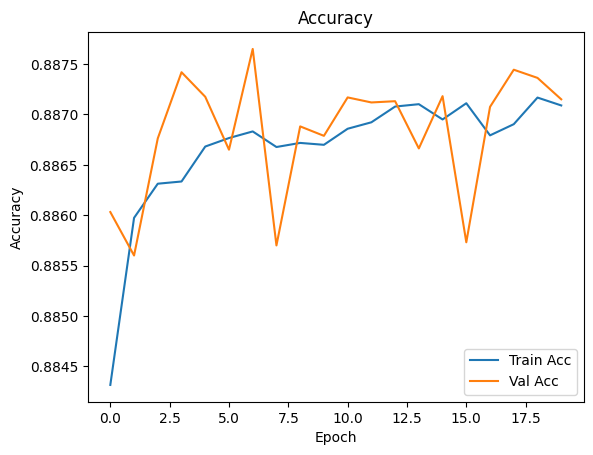

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8865 - loss: 0.2586
Test Accuracy: 0.8865


In [19]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history_cls.history['accuracy'], label='Train Acc')
plt.plot(history_cls.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Test evaluation
loss, acc = model_cls.evaluate(X_test_c, y_test_c)
print(f"Test Accuracy: {acc:.4f}")


###  Feature Importance (SHAP)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 956us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 890us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 985us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 946us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 803us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 841us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 905us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 863us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 962us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 984us/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 

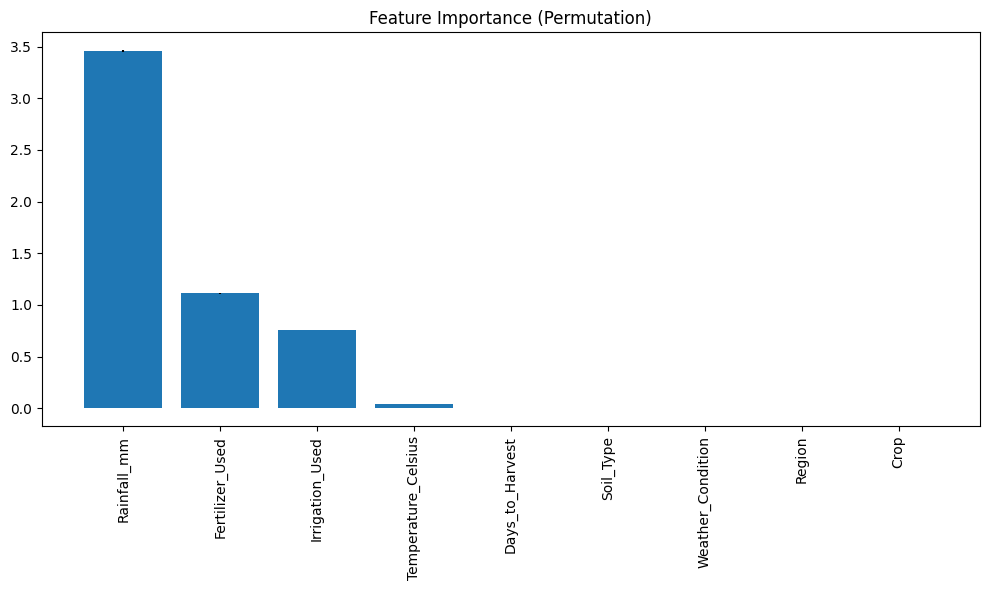

In [20]:
from sklearn.inspection import permutation_importance

# Use model.predict for regression or np.argmax(model.predict, axis=1) for classification
result = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=42)

# Plot
import matplotlib.pyplot as plt

importances = result.importances_mean
std = result.importances_std

indices = np.argsort(importances)[::-1]
features_list = features.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importance (Permutation)")
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), [features_list[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


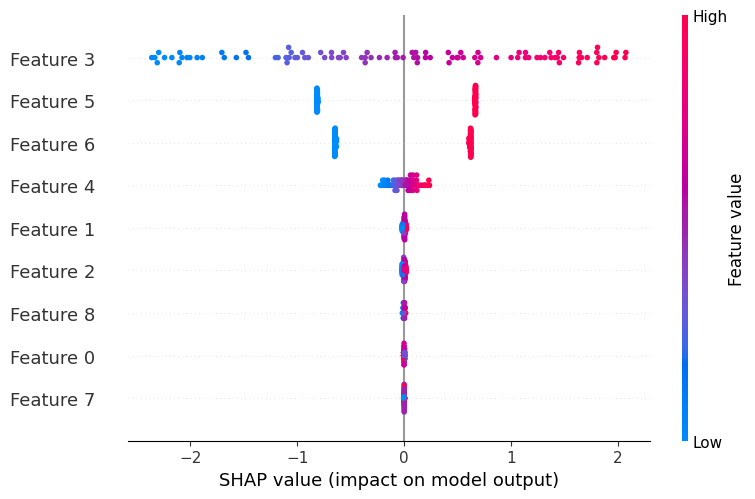

In [24]:
import shap

# Use smaller subset
sampled_X = X_test[:100]

# Create SHAP Explainer
explainer = shap.Explainer(model, sampled_X)
shap_values = explainer(sampled_X)

# Plot summary
shap.summary_plot(shap_values, sampled_X)


#  Final Summary

###  What I Did:
- Cleaned and preprocessed climate & crop data
- Engineered new features (rainfall anomaly, temp deviation)
- Built two deep learning models using MLP:
  - One for **regression** (yield prediction)
  - One for **classification** (yield category)
- Visualized performance with accuracy/loss plots
- Applied **SHAP** for explainability

###  Results:
- Regression RMSE: 0.2536562107508204
- Classification Accuracy: 0.8865
- Important features: Rainfall,Temperature, Crop Type, CO2 emissions

###  Insights:
- Climate factors have a strong impact on crop yield.
- Classification model helps identify risky yield zones.
- SHAP shows temperature & rainfall are key predictors.

###  Learnings:
- How to train MLP models in TensorFlow
- How to interpret model predictions with SHAP
- Data preprocessing and encoding techniques

###  Project Complete!
